# BANKING CUSTOMER QUESTIONS - DETAILED MODEL ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("BANKING CUSTOMER QUESTIONS - MODEL ANALYSIS")
print("=" * 50)

# Load model and data
print("Loading model and data...")
best_model = joblib.load('../models/best_model_logistic_regression.pkl')
vectorizer = joblib.load('../models/tfidf_vectorizer.pkl')
test_df = pd.read_csv('../data/processed/test_data.csv', encoding='utf-8')
train_df = pd.read_csv('../data/processed/train_data.csv', encoding='utf-8')

# Prepare features
X_test = vectorizer.transform(test_df['question_cleaned'])
y_test = test_df['department_target']
X_train = vectorizer.transform(train_df['question_cleaned'])
y_train = train_df['department_target']

# Generate predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

BANKING CUSTOMER QUESTIONS - MODEL ANALYSIS
Loading model and data...
Test Accuracy: 0.6964


## 1.CONFUSION MATRIX

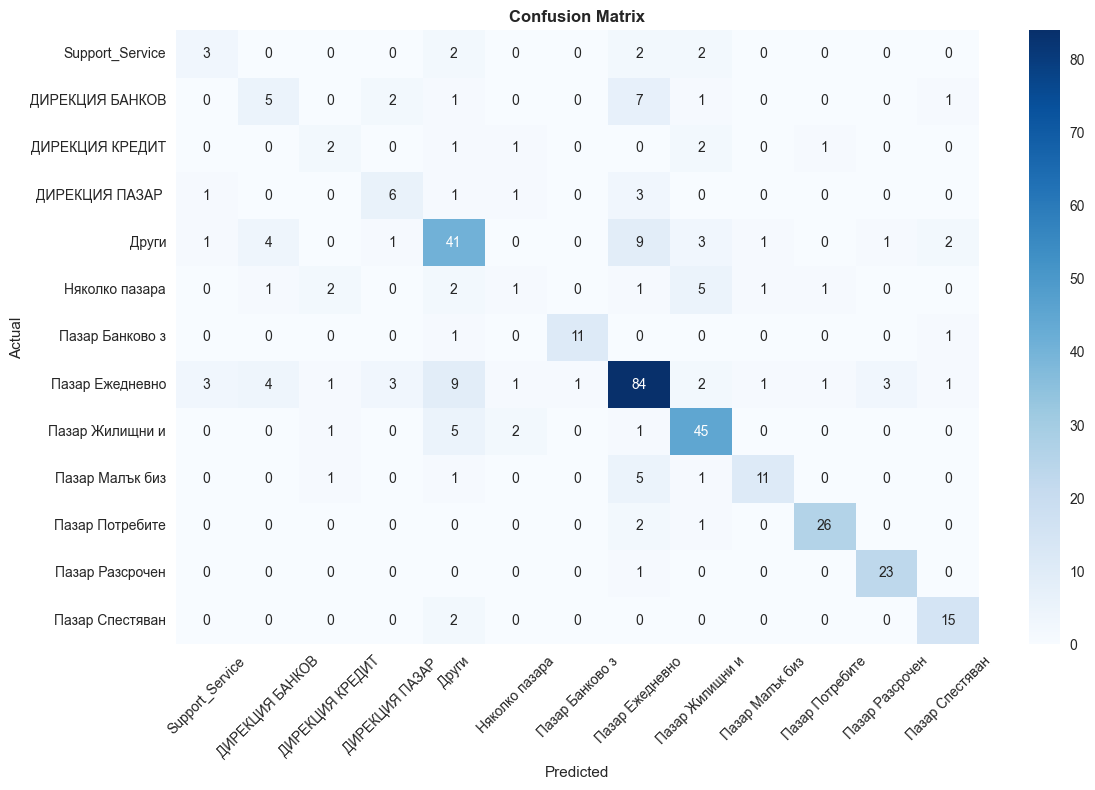

In [2]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = best_model.classes_

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[name[:15] for name in class_names],
            yticklabels=[name[:15] for name in class_names])
plt.title('Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.PER-CLASS PERFORMANCE

Performance by Department:
Department                     Precision  Recall     F1-Score   Support
----------------------------------------------------------------------
Support_Services               0.375      0.333      0.353      9
ДИРЕКЦИЯ БАНКОВИ ОПЕРАЦИИ      0.357      0.294      0.323      17
ДИРЕКЦИЯ КРЕДИТЕН РИСК ИНДИВИ  0.286      0.286      0.286      7
ДИРЕКЦИЯ ПАЗАР АТМ И КАСОВА Д  0.500      0.500      0.500      12
Други                          0.621      0.651      0.636      63
Няколко пазара                 0.167      0.071      0.100      14
Пазар Банково застраховане     0.917      0.846      0.880      13
Пазар Ежедневно банкиране      0.730      0.737      0.734      114
Пазар Жилищни и ипотечни кред  0.726      0.833      0.776      54
Пазар Малък бизнес             0.786      0.579      0.667      19
Пазар Потребителско кредитира  0.897      0.897      0.897      29
Пазар Разсрочени плащания      0.852      0.958      0.902      24
Пазар Спестяване и инвестиц

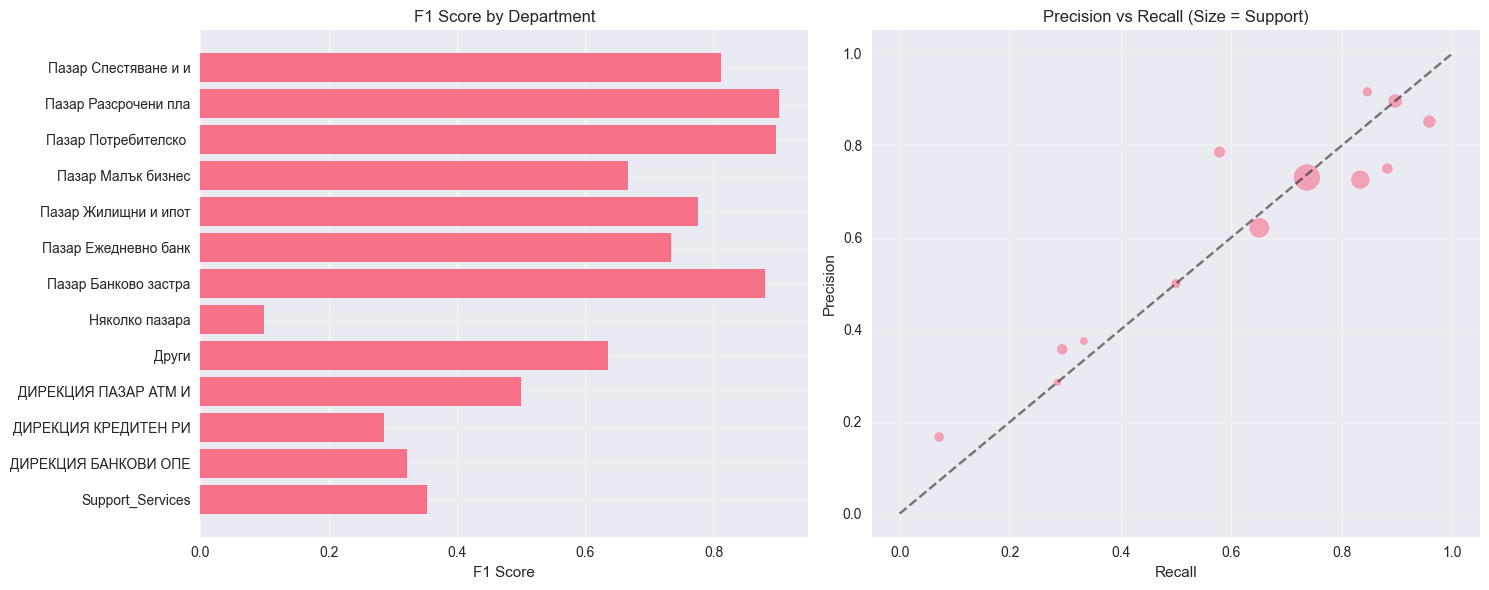

In [3]:
# Classification report
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("Performance by Department:")
print(f"{'Department':<30} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support'}")
print("-" * 70)
for dept in class_names:
    if dept in report:
        p = report[dept]['precision']
        r = report[dept]['recall'] 
        f1 = report[dept]['f1-score']
        s = int(report[dept]['support'])
        print(f"{dept[:29]:<30} {p:<10.3f} {r:<10.3f} {f1:<10.3f} {s}")

# Performance visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# F1 scores
f1_scores = [report[dept]['f1-score'] for dept in class_names if dept in report]
axes[0].barh(range(len(class_names)), f1_scores)
axes[0].set_yticks(range(len(class_names)))
axes[0].set_yticklabels([name[:20] for name in class_names])
axes[0].set_xlabel('F1 Score')
axes[0].set_title('F1 Score by Department')
axes[0].grid(True, alpha=0.3)

# Precision vs Recall
precisions = [report[dept]['precision'] for dept in class_names if dept in report]
recalls = [report[dept]['recall'] for dept in class_names if dept in report]
supports = [report[dept]['support'] for dept in class_names if dept in report]

axes[1].scatter(recalls, precisions, s=[s*3 for s in supports], alpha=0.6)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision vs Recall (Size = Support)')
axes[1].grid(True, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.tight_layout()
plt.show()

## 3.ERROR ANALYSIS

Total Errors: 119/392 (30.4%)
Average Confidence - Correct: 0.586, Wrong: 0.394

Most Confident Wrong Predictions:
  Conf: 0.770 | True: Няколко пазара | Pred: Пазар Жилищни и ипот
  Q: какви са преференциални условия: при потребителски, жилищен ...
  Conf: 0.757 | True: Пазар Малък бизнес | Pred: Пазар Ежедневно банк
  Q: план дск хоризонт...
  Conf: 0.752 | True: Пазар Ежедневно банк | Pred: ДИРЕКЦИЯ БАНКОВИ ОПЕ
  Q: каква е таксата за валутен превод?...
  Conf: 0.736 | True: Пазар Банково застра | Pred: Други
  Q: а ако кара ски като любител, а не като професионален спортис...
  Conf: 0.698 | True: Други | Pred: Пазар Разсрочени пла
  Q: зареден ли ми е лимита по кредитната карта?...


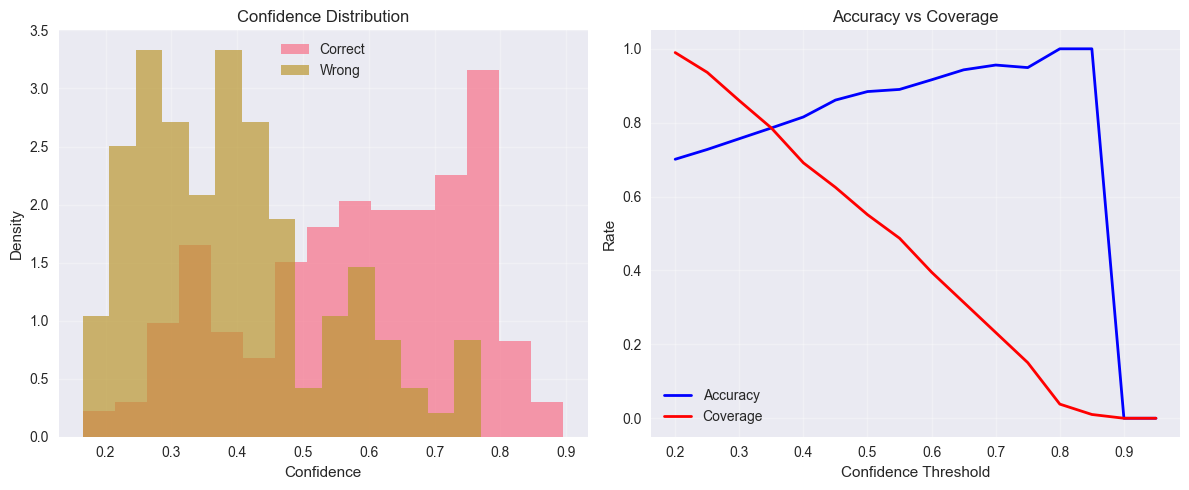

In [4]:
# Error analysis
errors_df = pd.DataFrame({
    'question': test_df['question_cleaned'],
    'true_dept': y_test,
    'pred_dept': y_pred,
    'correct': y_test == y_pred,
    'confidence': np.max(y_pred_proba, axis=1)
})

total_errors = len(errors_df[~errors_df['correct']])
print(f"Total Errors: {total_errors}/{len(errors_df)} ({total_errors/len(errors_df)*100:.1f}%)")

# Confidence analysis
correct_conf = errors_df[errors_df['correct']]['confidence'].mean()
wrong_conf = errors_df[~errors_df['correct']]['confidence'].mean()
print(f"Average Confidence - Correct: {correct_conf:.3f}, Wrong: {wrong_conf:.3f}")

# Most confident errors
print("\nMost Confident Wrong Predictions:")
wrong_preds = errors_df[~errors_df['correct']].nlargest(5, 'confidence')
for _, row in wrong_preds.iterrows():
    print(f"  Conf: {row['confidence']:.3f} | True: {row['true_dept'][:20]} | Pred: {row['pred_dept'][:20]}")
    print(f"  Q: {row['question'][:60]}...")

# Confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors_df[errors_df['correct']]['confidence'], bins=15, alpha=0.7, label='Correct', density=True)
plt.hist(errors_df[~errors_df['correct']]['confidence'], bins=15, alpha=0.7, label='Wrong', density=True)
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.title('Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy by confidence threshold
plt.subplot(1, 2, 2)
thresholds = np.arange(0.2, 1.0, 0.05)
accuracies = []
coverages = []

for t in thresholds:
    high_conf = errors_df[errors_df['confidence'] >= t]
    if len(high_conf) > 0:
        acc = high_conf['correct'].mean()
        cov = len(high_conf) / len(errors_df)
    else:
        acc, cov = 0, 0
    accuracies.append(acc)
    coverages.append(cov)

plt.plot(thresholds, accuracies, 'b-', label='Accuracy', linewidth=2)
plt.plot(thresholds, coverages, 'r-', label='Coverage', linewidth=2)
plt.xlabel('Confidence Threshold')
plt.ylabel('Rate')
plt.title('Accuracy vs Coverage')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. LEARNING CURVES

Generating learning curves...


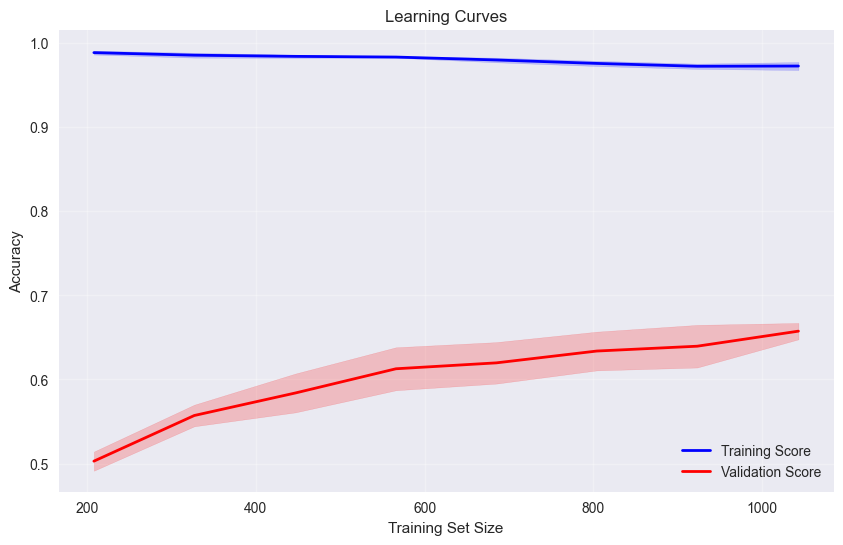

Final Training Score: 0.9728
Final Validation Score: 0.6575
Overfitting Gap: 0.3153
Assessment: High overfitting


In [5]:
print("Generating learning curves...")
train_sizes = np.linspace(0.2, 1.0, 8)
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    train_sizes=train_sizes,
    cv=3,  # Reduced for speed
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean, 'b-', label='Training Score', linewidth=2)
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes_abs, val_mean, 'r-', label='Validation Score', linewidth=2)
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

final_gap = train_mean[-1] - val_mean[-1]
print(f"Final Training Score: {train_mean[-1]:.4f}")
print(f"Final Validation Score: {val_mean[-1]:.4f}")
print(f"Overfitting Gap: {final_gap:.4f}")
print(f"Assessment: {'High overfitting' if final_gap > 0.1 else 'Moderate overfitting' if final_gap > 0.05 else 'Good fit'}")


## 5. EXPORT RESULTS

In [6]:
# Create analysis directory
import os
os.makedirs('../models/analysis', exist_ok=True)

print("Saving all visualizations...")

# 1. Save Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[name[:15] for name in class_names],
            yticklabels=[name[:15] for name in class_names])
plt.title('Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../models/analysis/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Save Performance Metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# F1 scores
f1_scores = [report[dept]['f1-score'] for dept in class_names if dept in report]
axes[0].barh(range(len(class_names)), f1_scores)
axes[0].set_yticks(range(len(class_names)))
axes[0].set_yticklabels([name[:20] for name in class_names])
axes[0].set_xlabel('F1 Score')
axes[0].set_title('F1 Score by Department')
axes[0].grid(True, alpha=0.3)

# Precision vs Recall
precisions = [report[dept]['precision'] for dept in class_names if dept in report]
recalls = [report[dept]['recall'] for dept in class_names if dept in report]
supports = [report[dept]['support'] for dept in class_names if dept in report]

axes[1].scatter(recalls, precisions, s=[s*3 for s in supports], alpha=0.6)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision vs Recall (Size = Support)')
axes[1].grid(True, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.tight_layout()
plt.savefig('../models/analysis/performance_metrics.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Save Confidence Analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors_df[errors_df['correct']]['confidence'], bins=15, alpha=0.7, label='Correct', density=True)
plt.hist(errors_df[~errors_df['correct']]['confidence'], bins=15, alpha=0.7, label='Wrong', density=True)
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.title('Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
thresholds = np.arange(0.2, 1.0, 0.05)
accuracies = []
coverages = []

for t in thresholds:
    high_conf = errors_df[errors_df['confidence'] >= t]
    if len(high_conf) > 0:
        acc = high_conf['correct'].mean()
        cov = len(high_conf) / len(errors_df)
    else:
        acc, cov = 0, 0
    accuracies.append(acc)
    coverages.append(cov)

plt.plot(thresholds, accuracies, 'b-', label='Accuracy', linewidth=2)
plt.plot(thresholds, coverages, 'r-', label='Coverage', linewidth=2)
plt.xlabel('Confidence Threshold')
plt.ylabel('Rate')
plt.title('Accuracy vs Coverage')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/analysis/confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Save Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean, 'b-', label='Training Score', linewidth=2)
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes_abs, val_mean, 'r-', label='Validation Score', linewidth=2)
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../models/analysis/learning_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Export data files
errors_df.to_csv('../models/analysis/error_analysis.csv', index=False, encoding='utf-8')

perf_data = []
for dept in class_names:
    if dept in report:
        perf_data.append({
            'Department': dept,
            'Precision': report[dept]['precision'],
            'Recall': report[dept]['recall'],
            'F1_Score': report[dept]['f1-score'],
            'Support': int(report[dept]['support'])
        })
        
perf_df = pd.DataFrame(perf_data)
perf_df.to_csv('../models/analysis/performance_by_department.csv', index=False, encoding='utf-8')

cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv('../models/analysis/confusion_matrix.csv', encoding='utf-8')

print("SAVED SUCCESSFULLY!")
print("\nVisualization files:")
print("  confusion_matrix.png")
print("  performance_metrics.png")
print("  confidence_analysis.png")
print("  learning_curves.png")

print("\nData files:")
print("  error_analysis.csv")
print("  performance_by_department.csv") 
print("  confusion_matrix.csv")

print(f"\nANALYSIS COMPLETE!")
print(f"Model shows {'good' if final_gap < 0.05 else 'moderate'} generalization with {accuracy_score(y_test, y_pred):.1%} test accuracy.")
print(f"All files saved to: ../models/analysis/")

Saving all visualizations...
SAVED SUCCESSFULLY!

Visualization files:
  confusion_matrix.png
  performance_metrics.png
  confidence_analysis.png
  learning_curves.png

Data files:
  error_analysis.csv
  performance_by_department.csv
  confusion_matrix.csv

ANALYSIS COMPLETE!
Model shows moderate generalization with 69.6% test accuracy.
All files saved to: ../models/analysis/
